In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [3]:
augmentation_transform = transforms.Compose([
                                    transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
                                    transforms.RandomRotation(10),     #Rotates the image to a specified angel
                                    transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
                                    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                               ])

In [4]:
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [4]:
batch_size = 64

original_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

augmented_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=augmentation_transform)

print(len(original_trainset))
print(len(augmented_trainset))

combined_train_dataset = torch.utils.data.ConcatDataset([original_trainset, augmented_trainset])

print(len(combined_train_dataset))

trainloader = torch.utils.data.DataLoader(combined_train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:09<00:00, 18311785.82it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
50000
50000
100000
Files already downloaded and verified


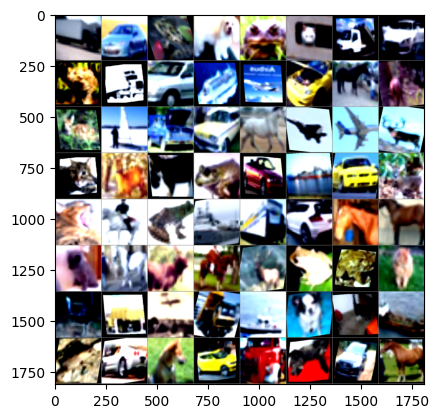

truck car   frog  dog   frog  cat   truck car   cat   truck car   ship  plane car   horse deer  deer  ship  car   car   horse plane plane deer  cat   deer  cat   frog  car   ship  car   deer  cat   horse frog  ship  truck car   horse horse cat   horse deer  horse deer  frog  frog  cat   bird  truck plane truck ship  dog   cat   ship  frog  car   dog   car   truck cat   car   horse


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [6]:
import torch.nn as nn
import torch.nn.functional as F

In [8]:
class LeNet(nn.Module):
    def __init__(self, n_classes: int = 10):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 =  nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [1]:
class AlexNet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4)
        self.pool = nn.MaxPool2d(3, stride=2)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(5 * 5 * 256, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 1000)
        self.fc4 = nn.Linear(1000, n_classes)
        self.dropout = nn.Dropout(0.4)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(F.relu(self.conv5(x)))
        x = torch.flatten(x, 1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

NameError: name 'nn' is not defined

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [11]:
model = AlexNet(10)

In [12]:
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

model.to(device)

AlexNet(
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=6400, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=1000, bias=True)
  (fc4): Linear(in_features=1000, out_features=10, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)

In [13]:
# model = LeNet(10).to(device)

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.001)

NameError: name 'model' is not defined

In [13]:
import copy

def train_model(model, train_data, optimizer, criterion, epochs=12, val_data=None, early_stopping=False, early_stopping_patience=5):
    """
        Reusable function to train a pytorch model.
        
        Input:
            model: PyTorch Model
            train_data: DataSet Loader with Train Data
            epochs: (default = 12) Number of epochs the model should be trained
            val_data: (Optional) DataSet Loader with Validation Data to perform the model on unseen data
            early_stopping: (default = False) Whether the training should stop early to avoid overfitting
            early_stopping_patience: (default = 5) Patience value for early stopping
            
        Returns:
            model: PyTorch model trained on the given data
            history: History of the values containing, Train loss, Train Accuracy, Val Loss and Val Accuracy (If validation data provided)
    
    """
    
    if val_data is None and early_stopping is True:
        raise ValueError("Early stopping is done based on the models performance on validation data, so inorder to perform early stopping, pass in validation data or set early_stopping = False")
    
    
    train_loader = train_data
    val_loader = val_data
    
    best_loss = float('inf')
    best_model_weights = None
    best_model_weights = copy.deepcopy(model.state_dict())
    history = {}
    history['train_loss'] = []
    history['val_loss'] = []
    history['train_accuracy'] = []
    history['val_accuracy'] = []
    
    for epoch in range(epochs):
        
        model.train() # model in train mode
        
        train_losses = []
        train_correct = 0
        train_total = 0
        
        for batch_num, input_data in enumerate(train_loader):
            optimizer.zero_grad()

            x, y = input_data
            x = x.to(device).float()
            y = y.to(device)

            output = model(x)

            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            _, predicted = torch.max(output.data, 1)
            train_total += y.size(0)
            train_correct += (predicted == y).sum().item()

            if batch_num % 500 == 0:
                print('\tEpoch %d | Batch %d | Loss %6.2f' % (epoch+1, batch_num, loss.item()))

        train_avg_loss = sum(train_losses) / len(train_losses)
        train_accuracy = 100 * train_correct / train_total
        print('Epoch %d | Training Loss %6.2f | Training Accuracy: %2.2f %%' % (epoch+1, train_avg_loss, train_accuracy))
        history['train_loss'].append(train_avg_loss)
        history['train_accuracy'].append(train_accuracy)

        if val_loader is not None:
            # Validation phase
            model.eval()
            
            val_losses = []
            val_correct = 0
            val_total = 0
            
            with torch.no_grad():
                for batch_num, val_data in enumerate(val_loader):
                    x, y = val_data
                    x = x.to(device).float()
                    y = y.to(device)

                    val_output = model(x)
                    val_loss = criterion(val_output, y)
                    val_losses.append(val_loss.item())
                    _, val_predicted = torch.max(val_output.data, 1)
                    val_total += y.size(0)
                    val_correct += (val_predicted == y).sum().item()

            val_avg_loss = sum(val_losses) / len(val_losses)
            val_accuracy = 100 * val_correct / val_total
            print('Epoch %d | Validation Loss %6.2f | Validation Accuracy: %2.2f %%' % (epoch+1, val_avg_loss, val_accuracy))
            history['val_loss'].append(val_avg_loss)
            history['val_accuracy'].append(val_accuracy)

        if early_stopping is not False:
            # Early stopping
            if val_avg_loss < best_loss:
                best_loss = val_avg_loss
                best_model_weights = copy.deepcopy(model.state_dict())  # Deep copy here 
                patience = early_stopping_patience  # Reset patience counter
                print(f"Saving the best model at {epoch+1}th epoch.")
            else:
                patience -= 1
                if patience == 0:
                    print(f"Stopping the training")
                    break

    # Load the best model weights
    model.load_state_dict(best_model_weights)
    
    return model, history

In [16]:
device

device(type='cuda', index=0)

In [17]:
model, history = train_model(model, trainloader, optimizer, criterion, 20, testloader,  True, 3)

	Epoch 0 | Batch 0 | Loss   2.30
	Epoch 0 | Batch 500 | Loss   2.01
	Epoch 0 | Batch 1000 | Loss   1.53
	Epoch 0 | Batch 1500 | Loss   1.64
Epoch 1 | Training Loss   1.79 | Training Accuracy: 33.10 %
Epoch 1 | Validation Loss   1.30 | Validation Accuracy: 52.44 %
Saving the best model at 1th epoch.
	Epoch 1 | Batch 0 | Loss   1.40
	Epoch 1 | Batch 500 | Loss   1.29
	Epoch 1 | Batch 1000 | Loss   0.79
	Epoch 1 | Batch 1500 | Loss   1.04
Epoch 2 | Training Loss   1.15 | Training Accuracy: 59.50 %
Epoch 2 | Validation Loss   0.91 | Validation Accuracy: 68.18 %
Saving the best model at 2th epoch.
	Epoch 2 | Batch 0 | Loss   0.95
	Epoch 2 | Batch 500 | Loss   0.65
	Epoch 2 | Batch 1000 | Loss   0.57
	Epoch 2 | Batch 1500 | Loss   0.72
Epoch 3 | Training Loss   0.85 | Training Accuracy: 70.81 %
Epoch 3 | Validation Loss   0.74 | Validation Accuracy: 74.83 %
Saving the best model at 3th epoch.
	Epoch 3 | Batch 0 | Loss   0.58
	Epoch 3 | Batch 500 | Loss   0.64
	Epoch 3 | Batch 1000 | Loss   0

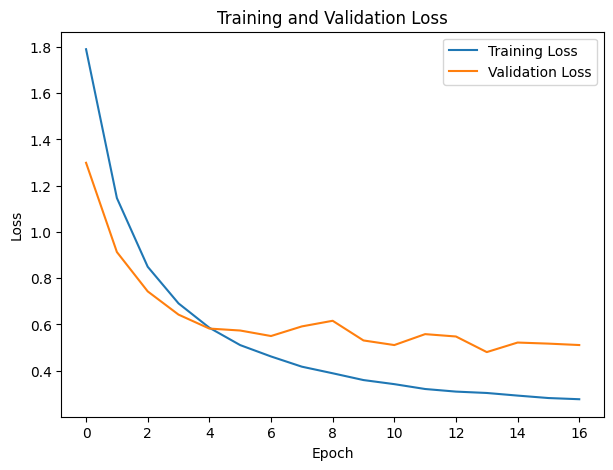

In [18]:
plt.figure(figsize=(7, 5))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

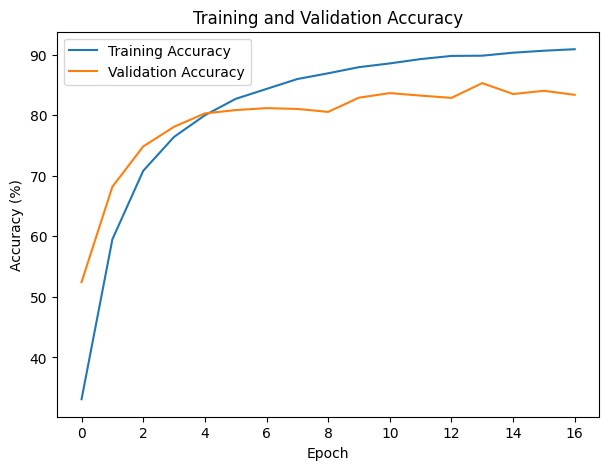

In [19]:
plt.figure(figsize=(7, 5))
plt.plot(history['train_accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

In [20]:
PATH = './cifar_alexnet.pth'
torch.save(model.state_dict(), PATH)

In [21]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device) 
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 85 %


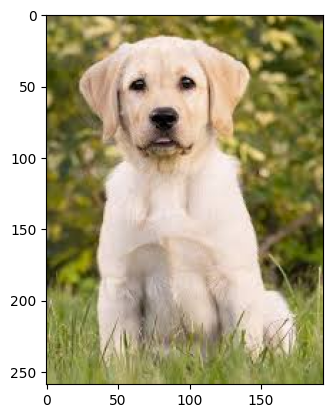

In [22]:
import requests
from PIL import Image

url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcT76mSMtKQWGstcqGi-0kPWJyVBqz8RCp8SuplMipkidRY0z9Mc&usqp=CAU'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

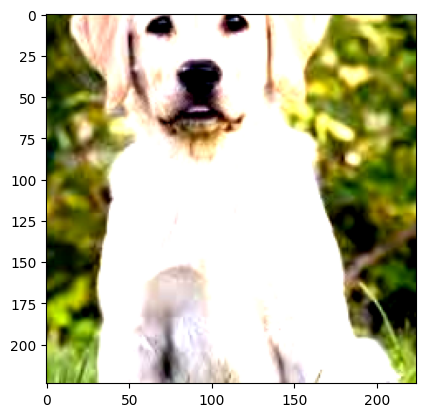

In [23]:
img = transform(img)  # applying the transformations on new image as our model has been trained on these transformations
imshow(img)

In [24]:
img.shape

torch.Size([3, 224, 224])

In [26]:
image = img.to(device).unsqueeze(0) # put inputs in device as our model is running there
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

dog


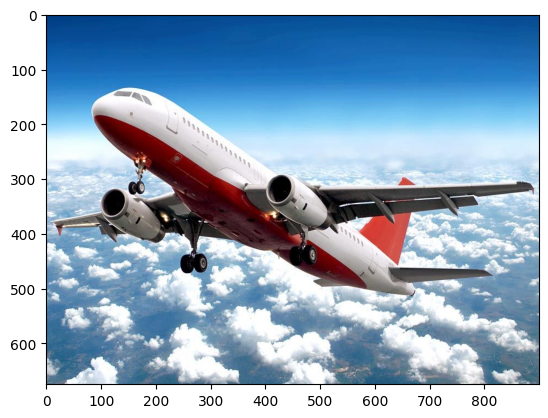

In [32]:
import requests
from PIL import Image

url = 'https://cdn.britannica.com/69/155469-131-14083F59/airplane-flight.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

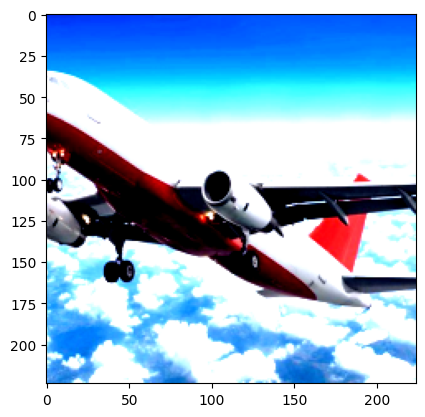

In [33]:
img = transform(img)  # applying the transformations on new image as our model has been trained on these transformations
imshow(img)

In [34]:
image = img.to(device).unsqueeze(0) # put inputs in device as our model is running there
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

plane


## Optimized Version of AlexNet

In [17]:
class AlexNetModified(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4)
        self.pool = nn.MaxPool2d(3, stride=2)
        self.bn1 = nn.BatchNorm2d(96)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(256)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(384)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(384)
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(5 * 5 * 256, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 1000)
        self.fc4 = nn.Linear(1000, n_classes)
        self.dropout = nn.Dropout(0.4)

        
        # initialising weights using the He Initialisation method for faster convergence
        for layer in [self.conv1, self.conv2, self.conv3, self.conv4, self.conv5]:
            torch.nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')

        
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))
        x = torch.flatten(x, 1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)        
        return x

In [28]:
model_improved = AlexNetModified(10).to(device)

In [29]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_improved.parameters(), lr=0.005, momentum=0.9, weight_decay=0.001)

In [30]:
model_improved, history = train_model(model_improved, trainloader, optimizer, criterion, 20, testloader,  True, 5)

	Epoch 1 | Batch 0 | Loss   2.31
	Epoch 1 | Batch 500 | Loss   1.18
	Epoch 1 | Batch 1000 | Loss   1.21
	Epoch 1 | Batch 1500 | Loss   1.20
Epoch 1 | Training Loss   1.37 | Training Accuracy: 50.11 %
Epoch 1 | Validation Loss   0.96 | Validation Accuracy: 66.27 %
Saving the best model at 1th epoch.
	Epoch 2 | Batch 0 | Loss   0.88
	Epoch 2 | Batch 500 | Loss   1.17
	Epoch 2 | Batch 1000 | Loss   1.03
	Epoch 2 | Batch 1500 | Loss   0.88
Epoch 2 | Training Loss   0.91 | Training Accuracy: 67.95 %
Epoch 2 | Validation Loss   0.78 | Validation Accuracy: 73.12 %
Saving the best model at 2th epoch.
	Epoch 3 | Batch 0 | Loss   0.88
	Epoch 3 | Batch 500 | Loss   0.95
	Epoch 3 | Batch 1000 | Loss   0.69
	Epoch 3 | Batch 1500 | Loss   0.74
Epoch 3 | Training Loss   0.73 | Training Accuracy: 74.94 %
Epoch 3 | Validation Loss   0.65 | Validation Accuracy: 77.44 %
Saving the best model at 3th epoch.
	Epoch 4 | Batch 0 | Loss   0.46
	Epoch 4 | Batch 500 | Loss   0.70
	Epoch 4 | Batch 1000 | Loss   0

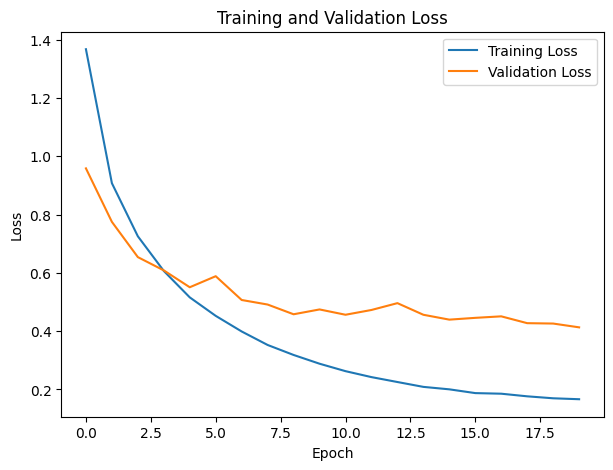

In [31]:
plt.figure(figsize=(7, 5))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

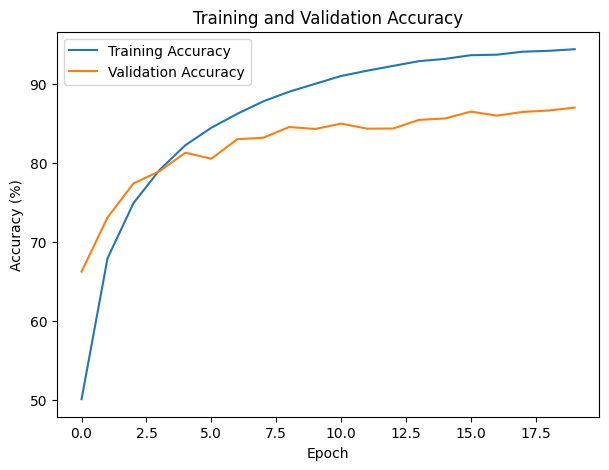

In [32]:
plt.figure(figsize=(7, 5))
plt.plot(history['train_accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

In [52]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device) 
        # calculate outputs by running images through the network
        outputs = model_improved(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
                
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 87 %
